In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Primeiro vamos definir as funções auxiliares da Quadtree:

In [2]:
class Canvas:
    def __init__(self, width, height):
        """ Inicializa um objeto Canvas com a largura e altura especificadas. """
        self.width = int(width)
        self.height = int(height)

    def contains(self, point):
        """ Verifica se um ponto dado está dentro do canvas. """
        try:
            point_x, point_y = point.x, point.y
        except AttributeError:
            point_x, point_y = point
        return (point_x >= 0 and point_x < self.width and
                point_y >= 0 and point_y < self.height)

class Point2D:
    def __init__(self, x, y, canvas=None):
        """ Inicializa um ponto 2D com coordenadas (x, y), opcionalmente limitado
        pelos limites de um canvas especificado. """
        if canvas:
            self.x = max(0, min(x, canvas.width))
            self.y = max(0, min(y, canvas.height))
        else:
            self.x, self.y = x, y
    
    def draw(self, ax, marker='o', color='b', label=None):
        """ Desenha o ponto 2D em um eixo matplotlib especificado. """
        ax.scatter(self.x, self.y, marker=marker, color=color, label=label)


class RegNode:
    def __init__(self, point, data):
        """Inicializa um objeto Node para um ponto com dados associados. """
        self.point = point
        self.data = data

class Rect:
    def __init__(self, cx, cy, w, h):
        """ Inicializa uma região retangular com um centro especificado (cx, cy),
        largura (largura) e altura (altura). """
        self.cx, self.cy = cx, cy
        self.w, self.h = w, h
        self.west_edge, self.east_edge = cx - w/2, cx + w/2
        self.north_edge, self.south_edge = cy - h/2, cy + h/2

    def contains(self, point):
        """ Verifica se um ponto dado está dentro da região retangular. """
        try:
            point_x, point_y = point.x, point.y
        except AttributeError:
            point_x, point_y = point
        return (point_x >= self.west_edge and
                point_x <  self.east_edge and
                point_y >= self.north_edge and
                point_y < self.south_edge)

    def intersects(self, other):
        """ Verifica se o retângulo intersecta com outro retângulo. """
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def draw(self, ax, c='k', lw=1, **kwargs):
        """ Desenha a região retangular em um eixo matplotlib especificado. """
        x1, y1 = self.west_edge, self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], c=c, lw=lw, **kwargs)

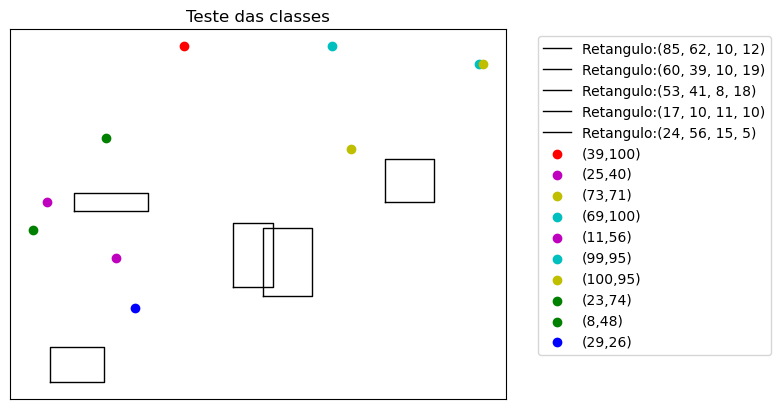

In [3]:
canvas = Canvas(100, 100)

num_rectangles = 5
rectangles = []
for _ in range(num_rectangles):
    cx = random.randint(10, 90)  
    cy = random.randint(10, 90)
    w = random.randint(5, 20)
    h = random.randint(5, 20)
    rectangles.append(Rect(cx, cy, w, h))

num_points = 10
points = []
for _ in range(num_points):
    x = random.randint(0, 105)
    y = random.randint(0, 105)
    points.append(Point2D(x, y, canvas))

for i, rect in enumerate(rectangles):
    points_inside = [point for point in points if rect.contains(point)]
    for point in points_inside:
        print(f"Ponto ({point.x}, {point.y}) etsá dentro do retangulo:{rect.cx, rect.cy, rect.w, rect.h}")

for i, rect in enumerate(rectangles):
    for j, point in enumerate(points):
        intersect_result = rect.contains(point)
        if intersect_result:
            print(f"Ponto ({point.x},{point.y}) intersecta o Retangulo:{rect.cx, rect.cy, rect.w, rect.h}")

# Show the canvas, rectangles, and points
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots()
for rect in rectangles:
    rect.draw(ax, label=f'Retangulo:{rect.cx, rect.cy, rect.w, rect.h}')
for point in points:
    point.draw(ax, color=color[random.randint(0,5)] , label=f'({point.x},{point.y})')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([])
ax.set_yticks([]) 
plt.title('Teste das classes')
plt.show()

In [6]:
class PRQuadTree:
    def __init__(self, canvas, points=None):
        """"Inicializa uma PR-Quadtree. """
        self.root = None
        self.canvas = canvas
        if points:
            for point in points:
                self.insert(point)

    def insert(self, point):
        """ Insere um objeto Point2D na PR-Quadtree. """
        if not self.canvas.contains(point):
            raise ValueError("O ponto está fora dos limites da área da tela.")

        if self.root is None:
            self.root = PRQuadNode(self.canvas, self.canvas.width, self.canvas.height, point)
        else:
            self.root.insert(point)

    def search(self, point):
        """ Procura por um objeto Point2D na PR-Quadtree. """
        if not self.root:
            return None
        return self.root.search(point)

    def query_window(self, rect, center_point=None, radius=None):
        """ Consulta pontos dentro de uma janela. """
        result = []
        if self.root:
            if radius is not None:
                # Consulta circular
                center = center_point if center_point is not None else Point2D(rect.cx, rect.cy)
                boundary = Rect(center.x - radius, center.y - radius, 2 * radius, 2 * radius)
                self.root.query_radius(boundary, center, radius, result)
            else:
                # Consulta retangular
                self.root.query_window(rect, result)

        return result

    def get_quadtree_rectangles(self):
        """ Retorna uma lista de retângulos representando a PR Quadtree. """
        rectangles = []
        if self.root:
            self.root.get_rectangles(rectangles)
        return rectangles    


class PRQuadNode:
    def __init__(self, canvas, width, height, point):
        """ Inicializa um nó na PR-Quadtree. """
        self.canvas = canvas
        self.width = width
        self.height = height
        self.point = point
        self.nw, self.ne, self.se, self.sw = None, None, None, None

    def insert(self, new_point):
        """ Insere um novo objeto Point2D no nó. """
        if self.point == new_point:
            return  # Evita duplicatas
        if self.is_leaf():
            # Converte o nó folha existente em um nó interno
            self.subdivide()
            self.insert_existing_point()
        # Insere o novo ponto no quadrante apropriado
        self.insert_new_point(new_point)

    def insert_existing_point(self):
        """ Insere o ponto existente no quadrante apropriado. """
        if self.point is not None:
            self.insert_new_point(self.point)
            self.point = None

    def insert_new_point(self, new_point):
        """ Insere um novo ponto no quadrante apropriado. """
        x, y = new_point.x, new_point.y
        cx, cy = self.canvas.width / 2, self.canvas.height / 2
        if x < cx:
            if y < cy:
                self.sw = PRQuadNode(self.canvas, cx, cy, new_point)
            else:
                self.nw = PRQuadNode(self.canvas, cx, cy, new_point)
        else:
            if y < cy:
                self.se = PRQuadNode(self.canvas, cx, cy, new_point)
            else:
                self.ne = PRQuadNode(self.canvas, cx, cy, new_point)

    def subdivide(self):
        """ Subdivide o nó atual em quatro quadrantes. """
        cx, cy = self.canvas.width / 2, self.canvas.height / 2
        self.nw = PRQuadNode(self.canvas, cx, cy, self.point)
        self.ne = PRQuadNode(self.canvas, cx, cy, self.point)
        self.se = PRQuadNode(self.canvas, cx, cy, self.point)
        self.sw = PRQuadNode(self.canvas, cx, cy, self.point)
        self.point = None  # Remove o ponto deste nó

    def is_leaf(self):
        """ Verifica se o nó é uma folha (contém um único ponto). """
        return self.point is not None

    def search(self, target_point):
        """ Procura por um objeto Point2D no nó ou em seus descendentes. """
        if self.is_leaf():
            return self.point if self.point == target_point else None

        if target_point.x < self.canvas.width / 2:
            if target_point.y < self.canvas.height / 2:
                return self.sw.search(target_point)
            else:
                return self.nw.search(target_point)
        else:
            if target_point.y < self.canvas.height / 2:
                return self.se.search(target_point)
            else:
                return self.ne.search(target_point)

    def query_window(self, rect, result, center_point=None, radius=None):
        """ Consulta os pontos dentro de uma janela de intervalo. """
        if self.is_leaf():
            if rect.contains(self.point) and (center_point is None or self.is_within_circle(center_point, radius)):
                result.append(self.point)

        if self.ne and rect.intersects(self.ne.get_rect()):
            self.ne.query_window(rect, result, center_point, radius)
        if self.nw and rect.intersects(self.nw.get_rect()):
            self.nw.query_window(rect, result, center_point, radius)
        if self.se and rect.intersects(self.se.get_rect()):
            self.se.query_window(rect, result, center_point, radius)
        if self.sw and rect.intersects(self.sw.get_rect()):
            self.sw.query_window(rect, result, center_point, radius)

    def query_radius(self, center_point, radius, result):
        """Consulta pontos dentro de um raio dado a partir do ponto central."""
        if self.is_leaf():
            distance = np.linalg.norm(np.array([self.point.x, self.point.y]) - np.array([center_point.x, center_point.y]))
            if distance <= radius:
                result.append(self.point)

        if self.ne and self.ne.intersects_circle(center_point, radius):
            self.ne.query_radius(center_point, radius, result)
        if self.nw and self.nw.intersects_circle(center_point, radius):
            self.nw.query_radius(center_point, radius, result)
        if self.se and self.se.intersects_circle(center_point, radius):
            self.se.query_radius(center_point, radius, result)
        if self.sw and self.sw.intersects_circle(center_point, radius):
            self.sw.query_radius(center_point, radius, result)

    def intersects_circle(self, center_point, radius):
        """Verificar se o retângulo do nó intersecta com o círculo."""
        cx, cy = self.canvas.width / 2, self.canvas.height / 2
        rect_center = np.array([cx, cy])
        distance = np.linalg.norm(rect_center - np.array([center_point.x, center_point.y]))
        return distance <= (radius + max(self.get_rect().width, self.get_rect().height) / 2)
    
    def get_rectangles(self, rectangles):
        """ Coleta retângulos da PR Quadtree. """
        rectangles.append(self.get_rect())
        if self.nw:
            self.nw.get_rectangles(rectangles)
        if self.ne:
            self.ne.get_rectangles(rectangles)
        if self.se:
            self.se.get_rectangles(rectangles)
        if self.sw:
            self.sw.get_rectangles(rectangles)
            
    def get_rect(self):
        """ Obtém o retângulo associado ao nó. """
        return Rect(self.canvas.width / 2, self.canvas.height / 2, self.width, self.height)

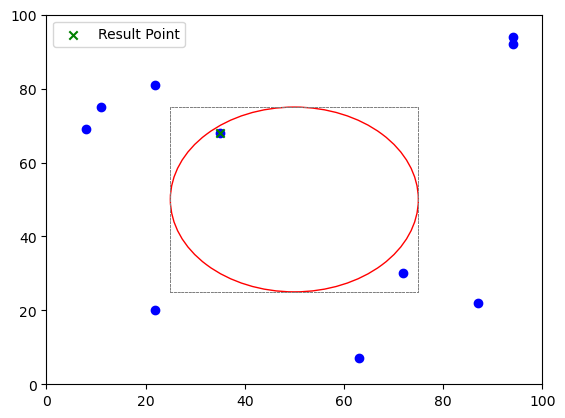

In [9]:
canvas = Canvas(width=100, height=100)
points = [Point2D(random.randint(0, canvas.width - 1), random.randint(0, canvas.height - 1)) for _ in range(10)]

quadtree = PRQuadTree(canvas, points)

center_point = Point2D(50, 50)
radius = 25
result = quadtree.query_window(Rect(center_point.x, center_point.y, 2 * radius, 2 * radius),
                                center_point=center_point)

# Plotting
fig, ax = plt.subplots()
ax.set_xlim([0, canvas.width])
ax.set_ylim([0, canvas.height])

quadtree_rectangles = quadtree.get_quadtree_rectangles()
for rectangle in quadtree_rectangles:
    rectangle.draw(ax, c='gray', lw=0.5, linestyle='--')

for point in points:
    point.draw(ax)

circle = plt.Circle((center_point.x, center_point.y), radius, color='r', fill=False)
ax.add_artist(circle)

if len(result) != 0:
    for point in result:
        point.draw(ax, marker='x', color='g', label='Result Point')
    plt.legend()
plt.show()